In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pickle
import random

rng = np.random.default_rng(926334)

In [2]:
ROOT = 'C:/Users/Matt/Documents/Python Scripts/SnowComp/realtime/'
MODIS_CNN_PATH = ROOT + 'model_32_18_8_3_0.13_50_1399_0.0001' #'modis_model'

import sys
sys.path.append(ROOT)

import torch
import captum.attr as attrib
from modis_cnn import Net as ModisNet

net_kwargs = {'cdim1': 32,
              'cdim2': 18,
              'cdim3': 8,
              'kernel_sz': 3,
              'dropout': 0.13,
              'ldim': 50}


modis_net = ModisNet(**net_kwargs)
modis_net.load_state_dict(torch.load(MODIS_CNN_PATH))

modis_net.eval()
print("\nModel is in evaluation mode")


c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 648

Model is in evaluation mode


In [4]:
#plotting helper
def masked_values(image):
    '''takes single channel image value:0...255
    returns ax object with masked value >100 plotted as red'''
    fig, ax  = plt.subplots(1,2)
    
    image[image > 100] = np.nan
    
    current_cmap = cm.get_cmap().copy()
    current_cmap.set_bad(color='red')
    
    ax[0].imshow(image[0,0,0:3,0:3])
    ax[1].imshow(image[0,1,0:3,0:3])

    return fig, ax
    

## Filter activations

Moving an image in the direction that maximizes a given filter


Morning vs evening Terra vs Aqua?

TODO: turn above 100 into a seperate color (red)

TODO: do for some images

In [5]:
neuron_gb = attrib.NeuronGuidedBackprop(modis_net, modis_net.conv1)
inp = torch.randn(1, 2, 21, 21, requires_grad=True) #2 examples, a+t sats, 21x21

attribution = neuron_gb.attribute(inp, (3,0,0)).numpy() #conv1: (0...32, 0...19, 0...19)

C:\Users\Matt\miniconda3\envs\snowcomp\lib\site-packages\captum\attr\_core\neuron\neuron_guided_backprop_deconvnet.py:336: UserWarning: Attribution to neuron output is no longer supported for NeuronGuidedBackprop and will be deprecated in Captum 0.6.0 due to changes in PyTorch's full backward hook behavior. To obtain attributions for a neuron's output, please attribute with respect to the next layer's input
  warnings.warn(
C:\Users\Matt\miniconda3\envs\snowcomp\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


(array([  4.,   0.,   0., 433.,   0.,   0.,   1.,   0.,   2.,   1.]),
 array([-0.16672872, -0.11995509, -0.07318144, -0.02640781,  0.02036583,
         0.06713947,  0.1139131 ,  0.16068675,  0.20746039,  0.25423402,
         0.30100766], dtype=float32),
 <BarContainer object of 10 artists>)

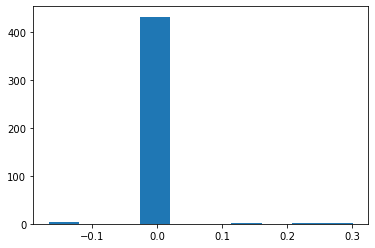

In [6]:
plt.hist(attribution[0,1].flatten())

(1, 2, 21, 21)


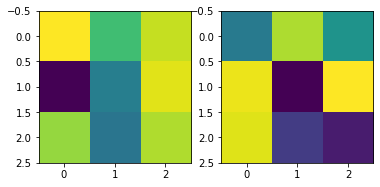

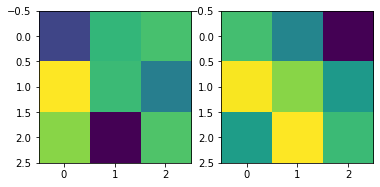

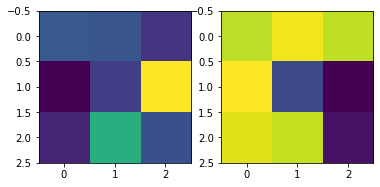

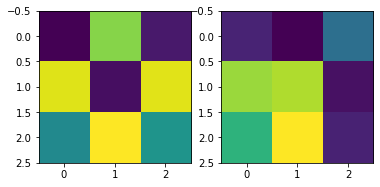

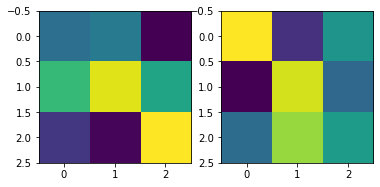

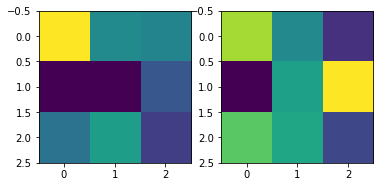

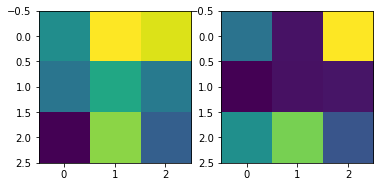

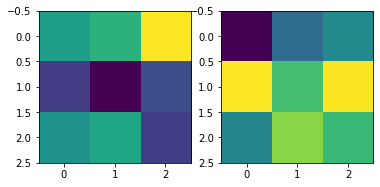

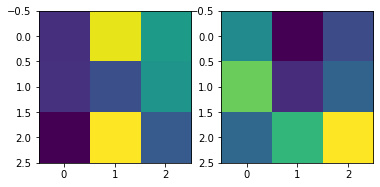

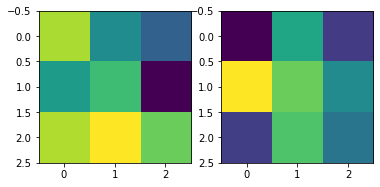

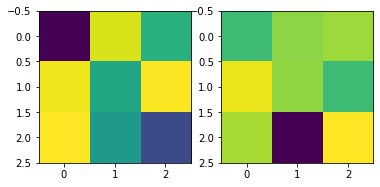

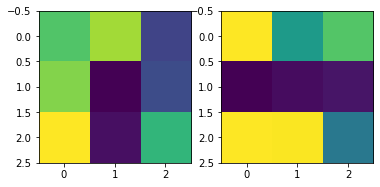

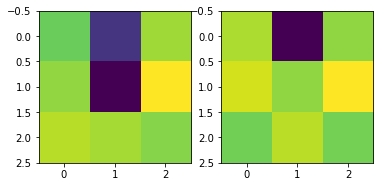

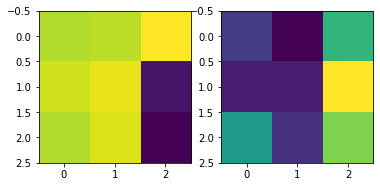

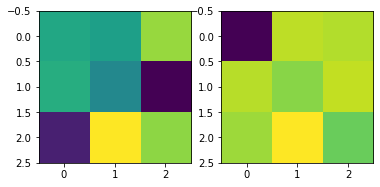

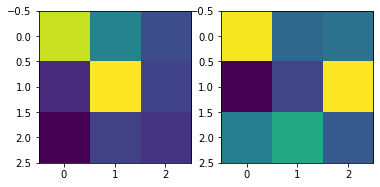

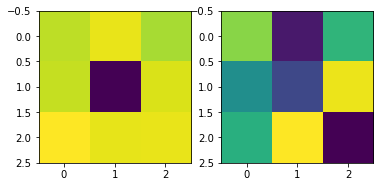

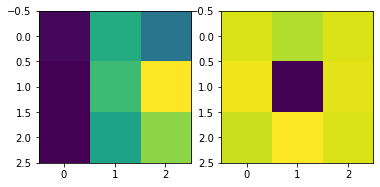

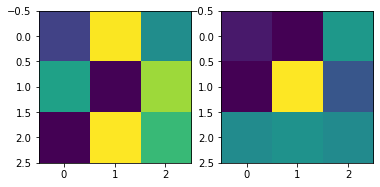

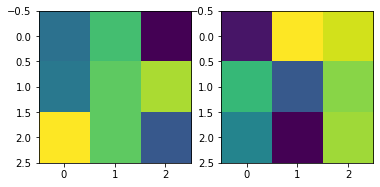

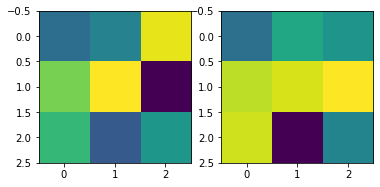

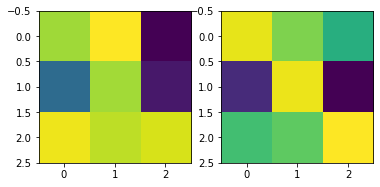

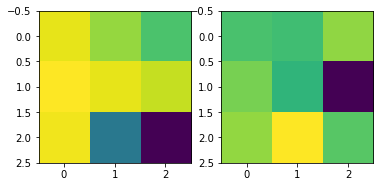

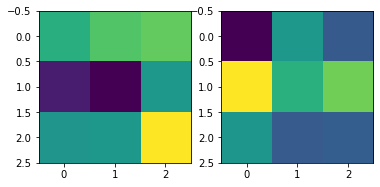

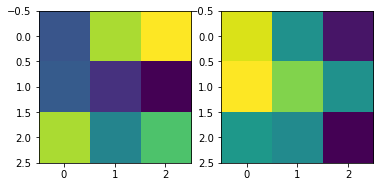

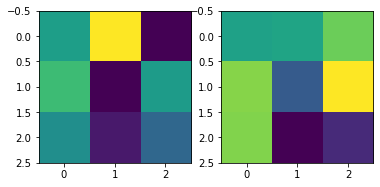

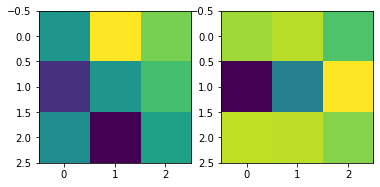

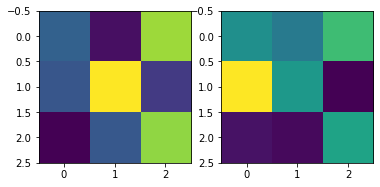

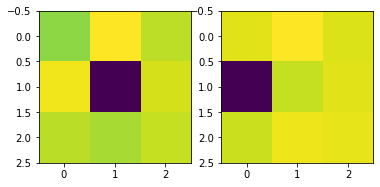

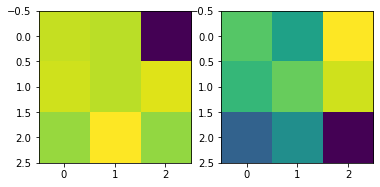

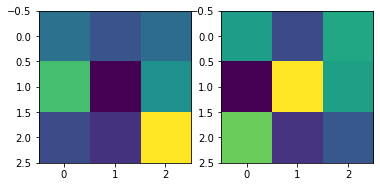

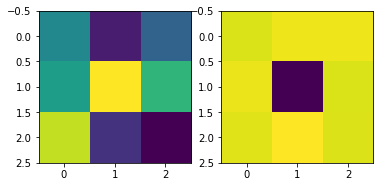

In [7]:
print(attribution.shape)
# plt.imshow(attribution[0,1])

for filt in range(32):
    attribution = neuron_gb.attribute(inp, (filt,0,0)).numpy()
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(attribution[0,0,0:3,0:3])
    ax[1].imshow(attribution[0,1,0:3,0:3])
    
    plt.show()
    
# attribution = neuron_gb.attribute(inp, (3,0,0))

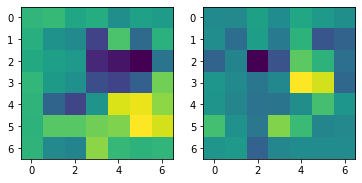

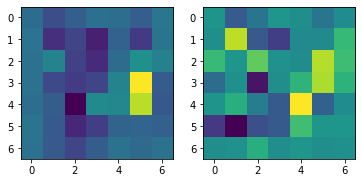

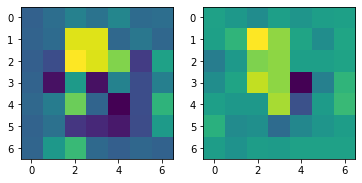

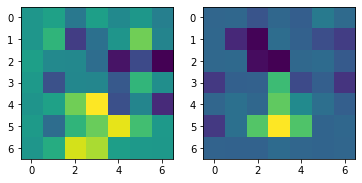

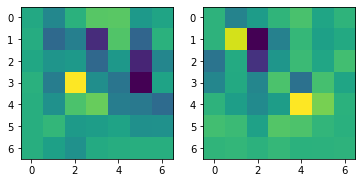

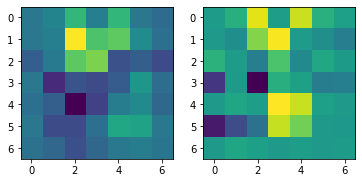

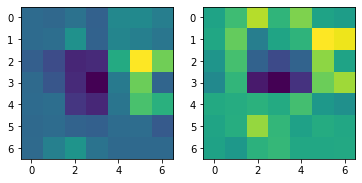

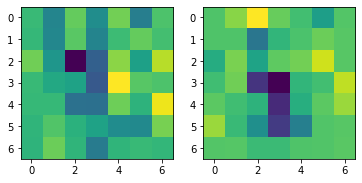

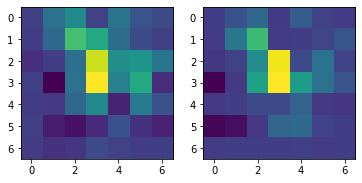

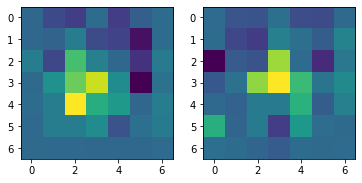

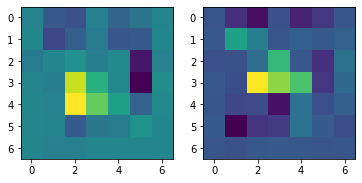

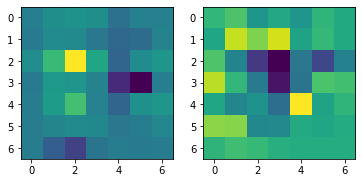

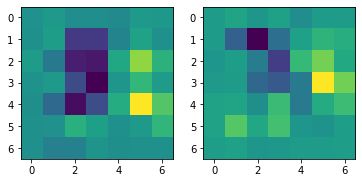

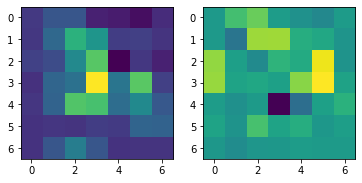

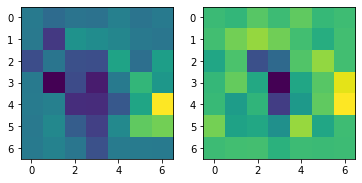

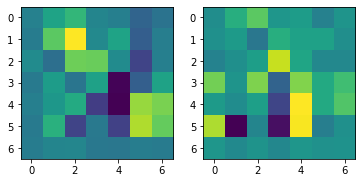

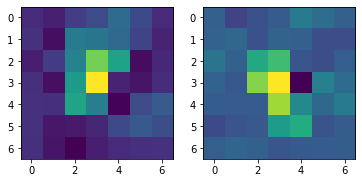

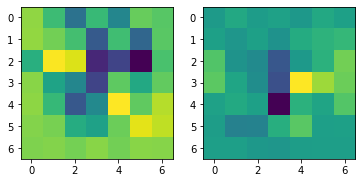

In [8]:
neuron_gb = attrib.NeuronGuidedBackprop(modis_net, modis_net.conv2)
# attribution = neuron_gb.attribute(inp, (3,6,6)).numpy() #conv2: (0...18, 0...15, 0...15)
# print(attribution.shape)
# plt.imshow(attribution[0,1])

for filt in range(18):
    attribution = neuron_gb.attribute(inp, (filt,7,7)).numpy()
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(attribution[0,0,7:14,7:14])
    ax[1].imshow(attribution[0,1,7:14,7:14])

#     ax[1].imshow(attribution[0,0])
    
    plt.show()

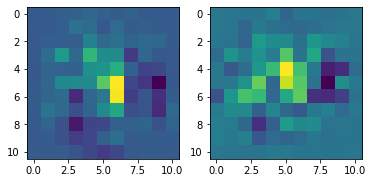

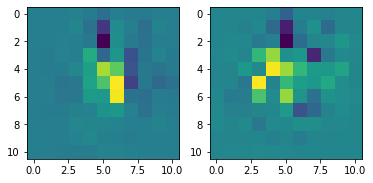

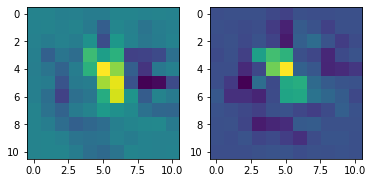

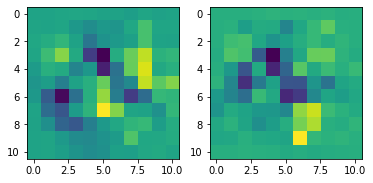

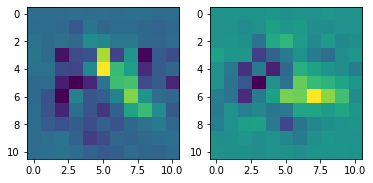

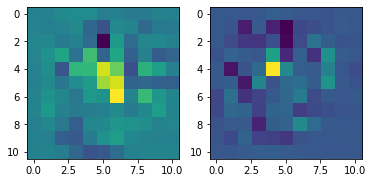

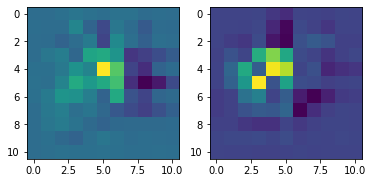

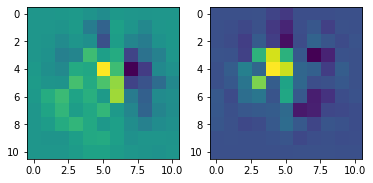

In [9]:
neuron_gb = attrib.NeuronGuidedBackprop(modis_net, modis_net.conv3)
attribution = neuron_gb.attribute(inp, (3,6,6)).numpy() #conv3: (0...8, 0...11, 0...11)
# print(attribution.shape)
# plt.imshow(attribution[0,1])

shift = 11
start = 4
for filt in range(8):
    attribution = neuron_gb.attribute(inp, (filt,start,start)).numpy()
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(attribution[0,0,start:(start+shift),start:(start+shift)])
    ax[1].imshow(attribution[0,1,start:(start+shift),start:(start+shift)])
#     ax[1].imshow(attribution[0,0])
    
    plt.show()

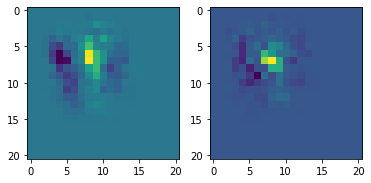

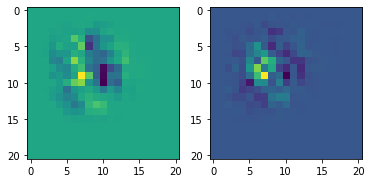

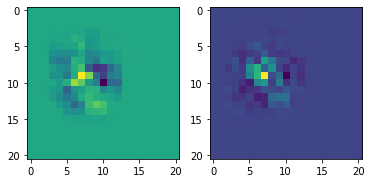

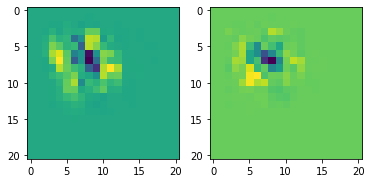

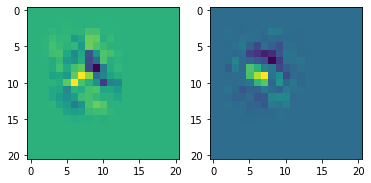

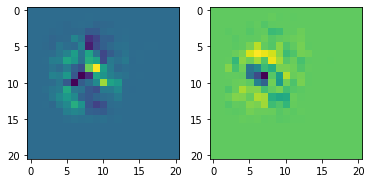

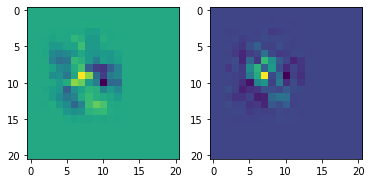

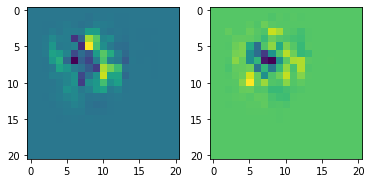

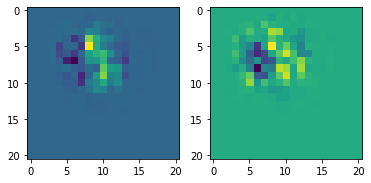

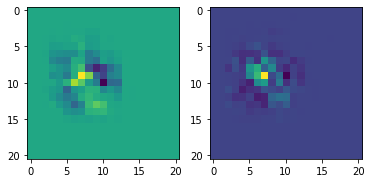

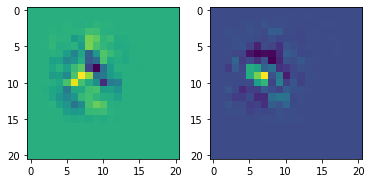

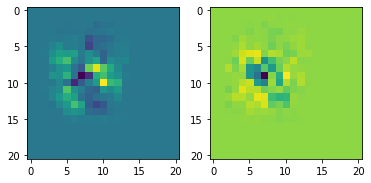

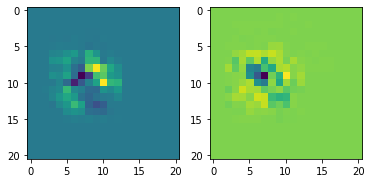

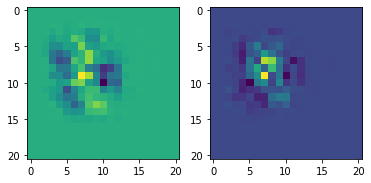

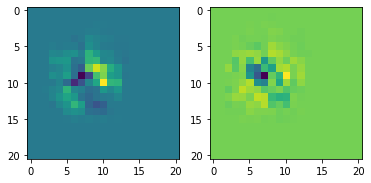

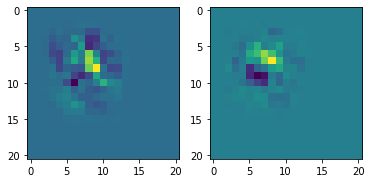

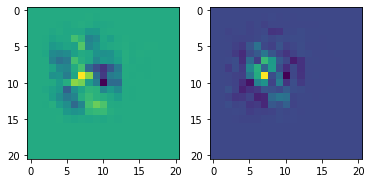

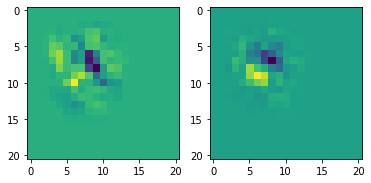

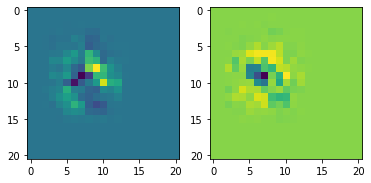

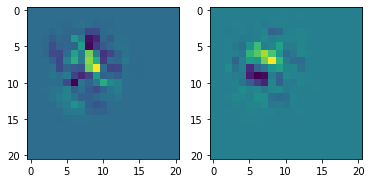

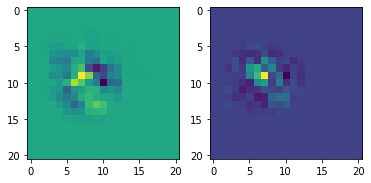

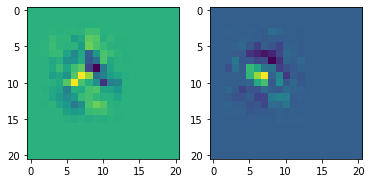

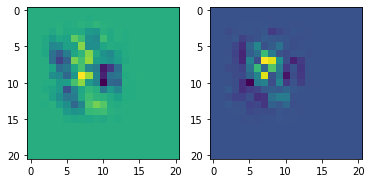

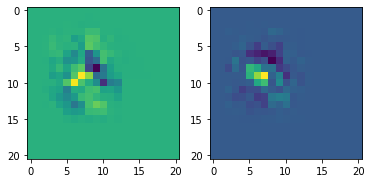

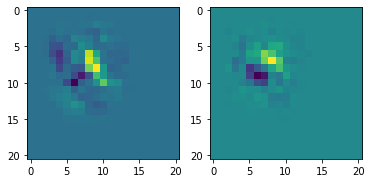

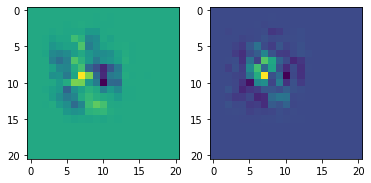

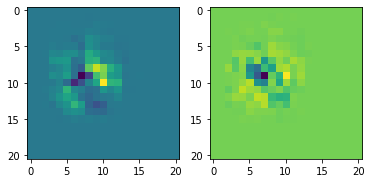

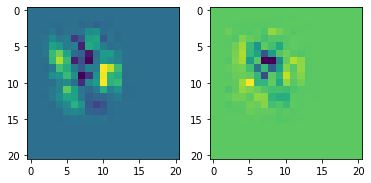

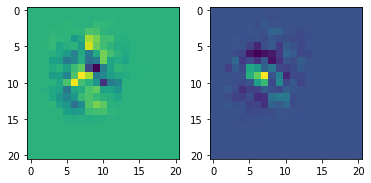

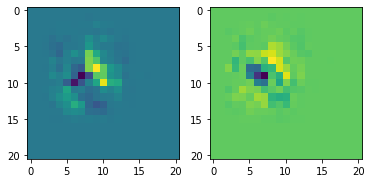

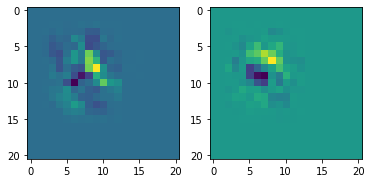

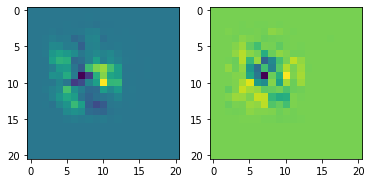

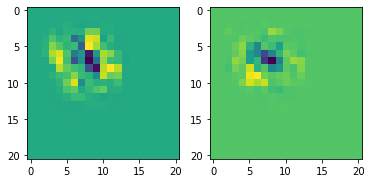

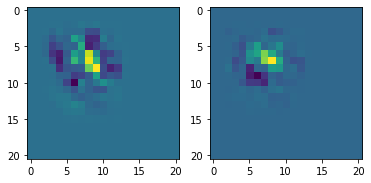

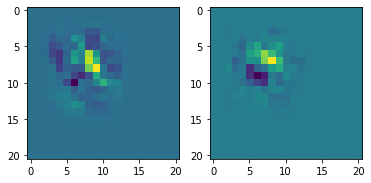

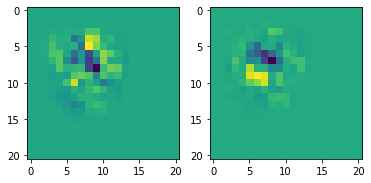

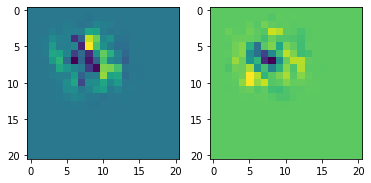

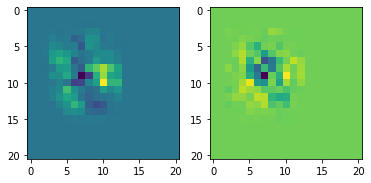

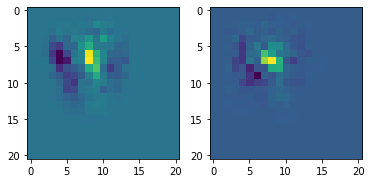

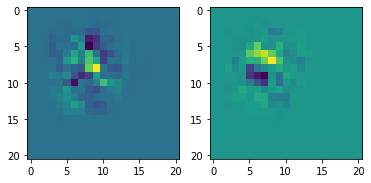

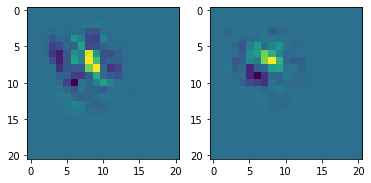

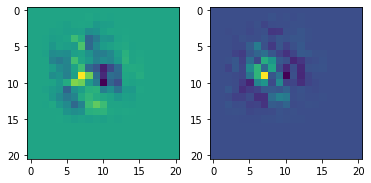

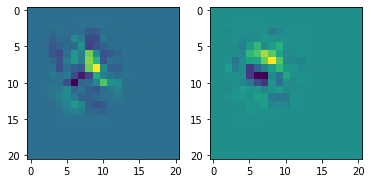

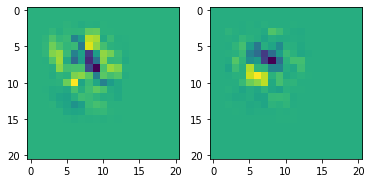

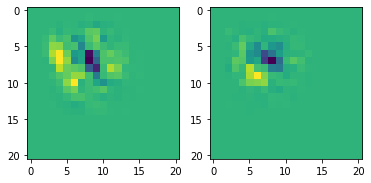

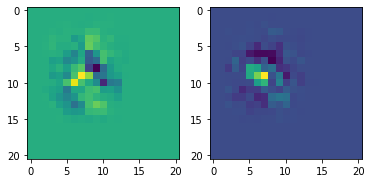

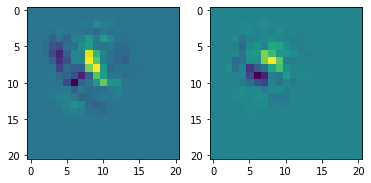

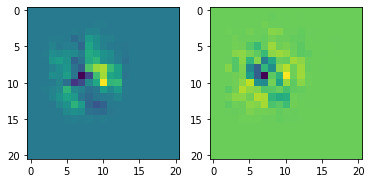

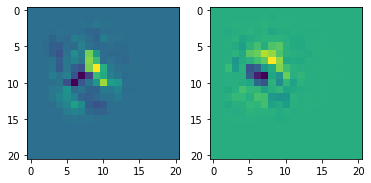

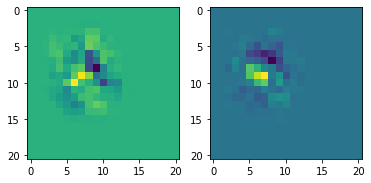

In [10]:
neuron_gb = attrib.NeuronGuidedBackprop(modis_net, modis_net.fc1)
attribution = neuron_gb.attribute(inp, 2).numpy() #fc1: (0...50)
# print(attribution.shape)
# plt.imshow(attribution[0,1])

for filt in range(50):
    attribution = neuron_gb.attribute(inp, filt).numpy()
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(attribution[0,0])
    ax[1].imshow(attribution[0,1])
#     ax[1].imshow(attribution[0,0])
    
    plt.show()

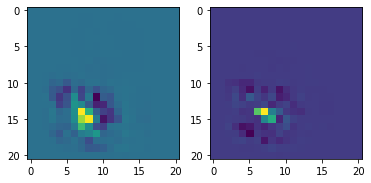

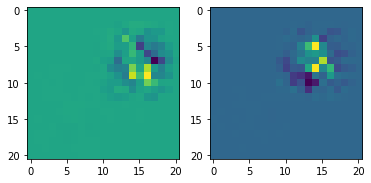

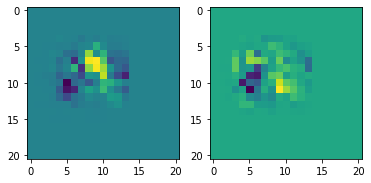

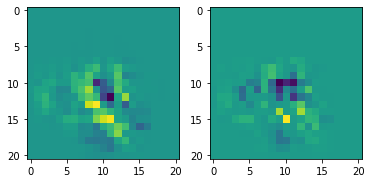

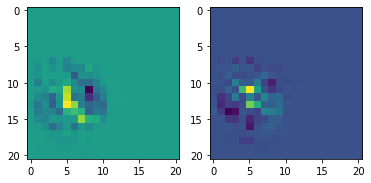

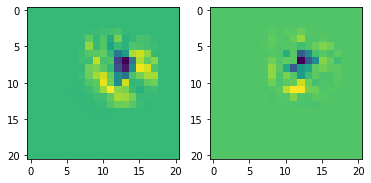

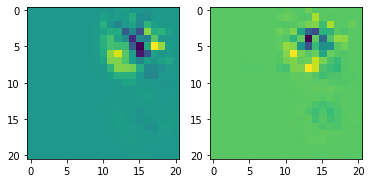

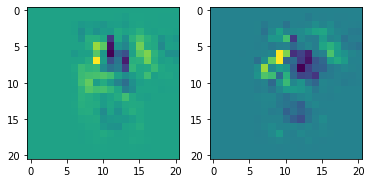

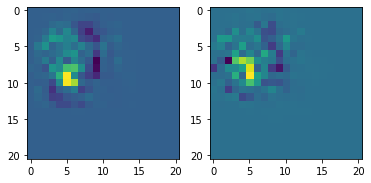

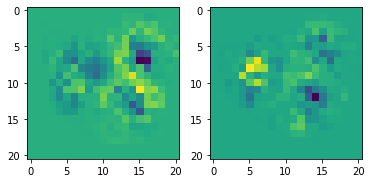

In [11]:
neuron_gb = attrib.NeuronGuidedBackprop(modis_net, modis_net.fc2)
inp_large = torch.randn(10, 2, 21, 21, requires_grad=True)
attribution = neuron_gb.attribute(inp_large, 0).numpy() #fc1: (0...50)

# print(attribution.shape)
# plt.imshow(attribution[0,1])

for ex in range(10):
    attribution = neuron_gb.attribute(inp_large[ex:ex+1], 0).numpy()
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(attribution[0,0])
    ax[1].imshow(attribution[0,1])
#     ax[1].imshow(attribution[0,0])
    
    plt.show()

## Integrated Gradients